<a href="https://colab.research.google.com/github/ROARMarketingConcepts/Machine-Learning-Projects/blob/master/Predict_Future_Sales_Coursera_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Predicting Future Sales - Coursera Challenge

Performed by
Ken Wood

ROAR Marketing Concepts LLC

ken@roarmarketingconcepts.com


### This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition we work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are being asked to predict total sales for every product and store in the next month. By solving this competition we will be able to apply and enhance our data science skills.

### Mount the Google Drive where the datasets are located...

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Install some necessary packages to perform the required analysis...

In [2]:
!pip install -U scikit-learn
!pip install --user --upgrade tables

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

%matplotlib inline

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.2)
Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.4.4)


Using TensorFlow backend.


### Load the datasets..

In [0]:
train = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Predict Future Sales - Coursera Challenge/Datasets/sales_train.csv')
items = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Predict Future Sales - Coursera Challenge/Datasets/items.csv')
item_cats = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Predict Future Sales - Coursera Challenge/Datasets/item_categories.csv')
shops = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Predict Future Sales - Coursera Challenge/Datasets/shops.csv')
test = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Predict Future Sales - Coursera Challenge/Datasets/test.csv')

### Let's look at some properties of the datasets...

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [7]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [8]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [9]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
item_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [11]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [12]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [13]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### A quick check shows that we have no missing values in any of the datasets...good!!

In [14]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [15]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [16]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [17]:
item_cats.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [18]:
shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

### Employing best data science practices, we will check to see if all values for  'shop_id' and 'item_id in the test set are also in the training set.

In [0]:
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]  # Filter out 'shop_id' rows in training set that are not in the test set.
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]  # Filter out 'item_id' rows in training set that are not in the test set.

In [0]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

In [21]:
grouped_data = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
grouped_data.head(20)

,shop_id,date_block_num,item_cnt_day
0,2,0,248.0
1,2,1,135.0
2,2,2,237.0
3,2,3,168.0
4,2,4,159.0
5,2,5,255.0
6,2,6,242.0
7,2,7,257.0
8,2,8,403.0
9,2,9,345.0


### We want to plot a maximum of 6 'shop_id's per graph.

### For count = 0,  result = selected rows from grouped_data where (0 x id_per_graph <= grouped_data['shop_id']) & (grouped_data['shop_id'] is less than 1 x id_per_graph = 1 x 6 = 6).

### For count = 1,  result = selected rows from grouped_data where (1 x id_per_graph <= grouped_data['shop_id']) & (grouped_data['shop_id'] is less than 2 x id_per_graph = 2 x 6 = 12).

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


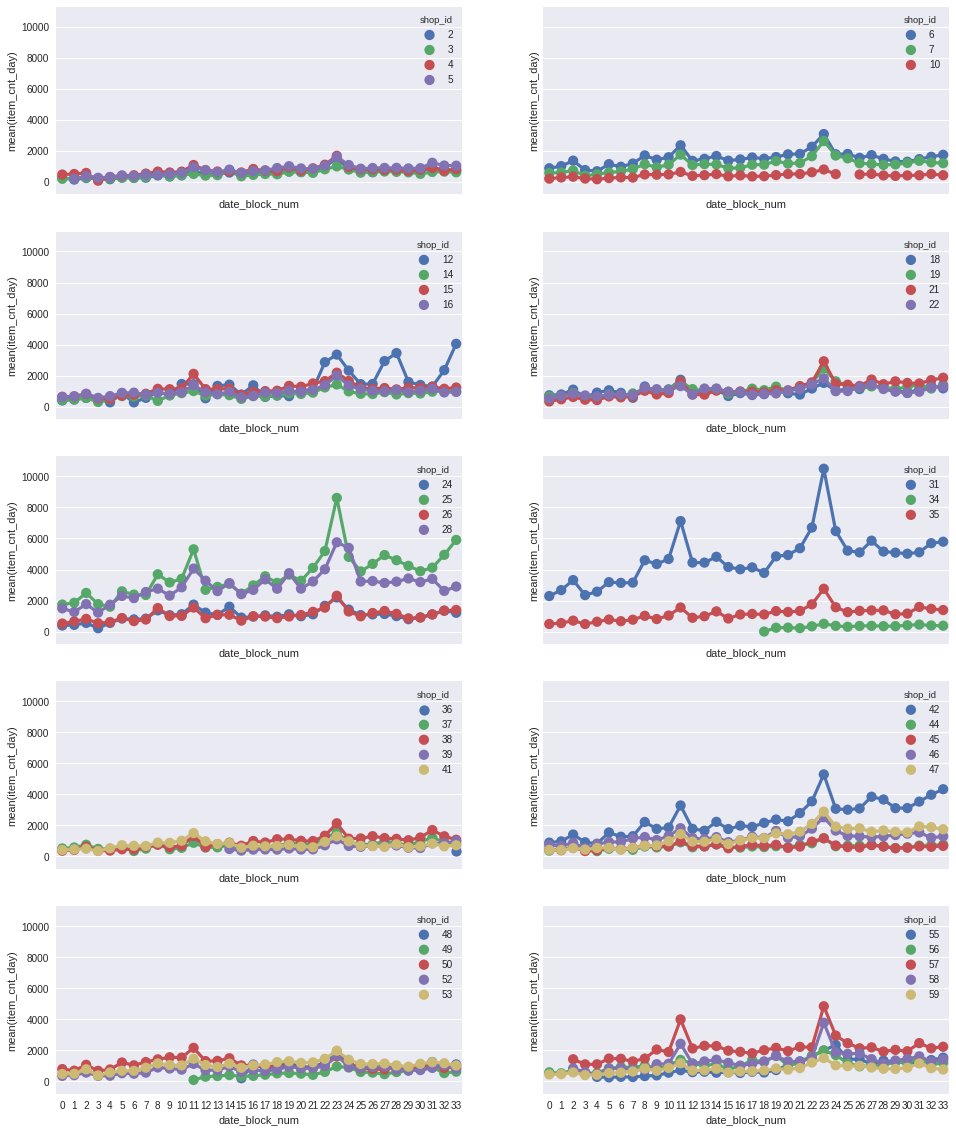

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))

num_graph = 10
id_per_graph = ceil(grouped_data.shop_id.max()/num_graph)  # = 6
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id',
                      data=grouped_data[np.logical_and(count*id_per_graph <= grouped_data['shop_id'],
                                                  grouped_data['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

There is a peak in the value for 'item_cnt_day' at the end of the year, probably due to the holiday season. Therefore, it would be beneficial to add month and year, so that the network can pickup this pattern. It would be nice to see how each item sale is going. However, given the number of items, it would be more beneficial if we look at how each item categories is doing instead.

### Now we need to merge the datasets on the appropriate keys. 

In [23]:
train = train.merge(items,how='left',on='item_id')
train.drop('item_name',axis=1,inplace=True)
train.set_index('item_id',inplace=True)
train.head(20)

,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id
item_id,,,,,,
22154,02.01.2013,0,59,999.0,1.0,37
2574,03.01.2013,0,25,399.0,2.0,55
2574,05.01.2013,0,25,399.0,1.0,55
2574,07.01.2013,0,25,399.0,1.0,55
2574,08.01.2013,0,25,399.0,2.0,55
2574,10.01.2013,0,25,399.0,1.0,55
2574,11.01.2013,0,25,399.0,2.0,55
2574,13.01.2013,0,25,399.0,1.0,55
2574,16.01.2013,0,25,399.0,1.0,55


### Now that we have merged the appropriate datasets, let's build out the datetime variable.

In [0]:
train['date'] = pd.to_datetime(train['date'],format = '%d.%m.%Y')

train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
month_dict = {1:"Jan",2:"Feb", 3:"Mar", 4:"Apr", 5:"May",6: "Jun", 7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
train['month_name'] = train['month'].map(month_dict)     # Get month name from month number
train['day_of_month'] = train['date'].dt.day
train['day_of_week_name'] = train['date'].dt.weekday_name


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


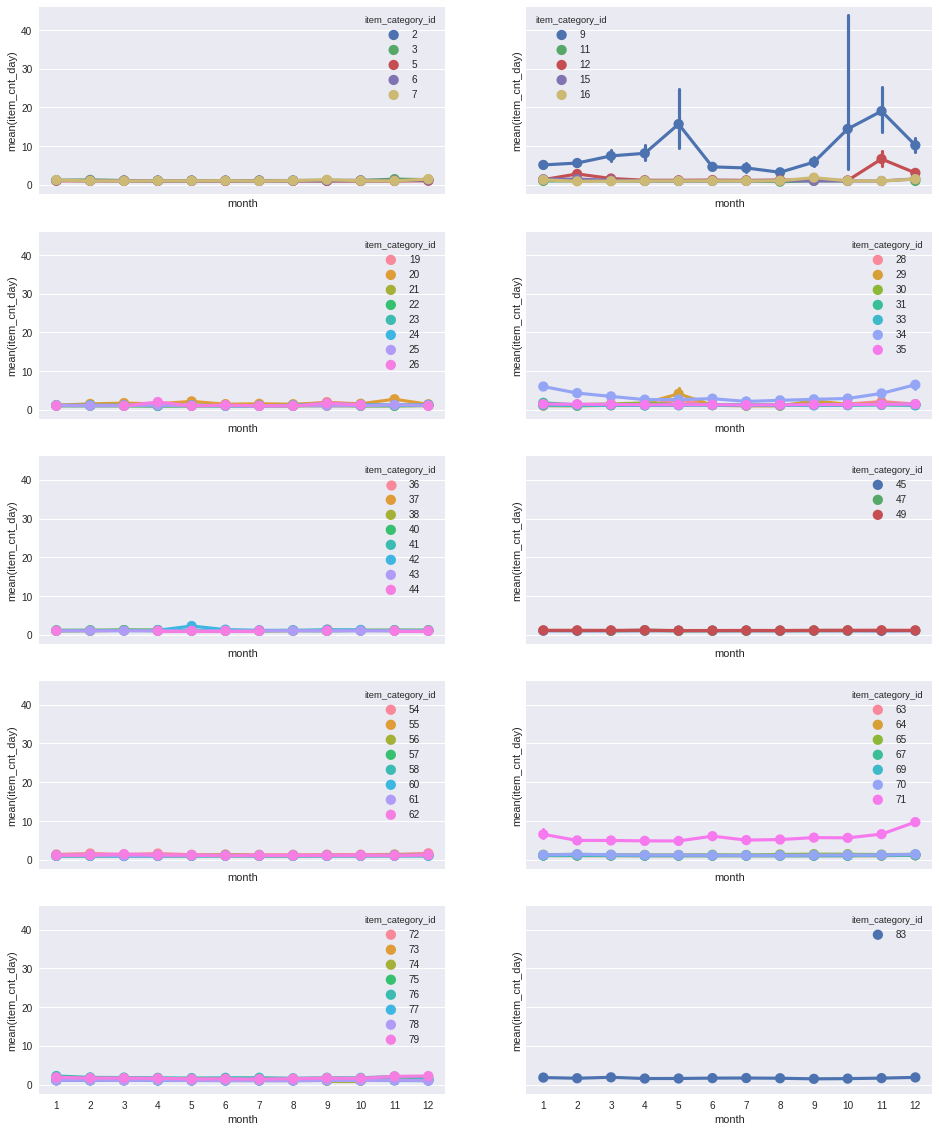

In [25]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))

num_graph = 10

id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


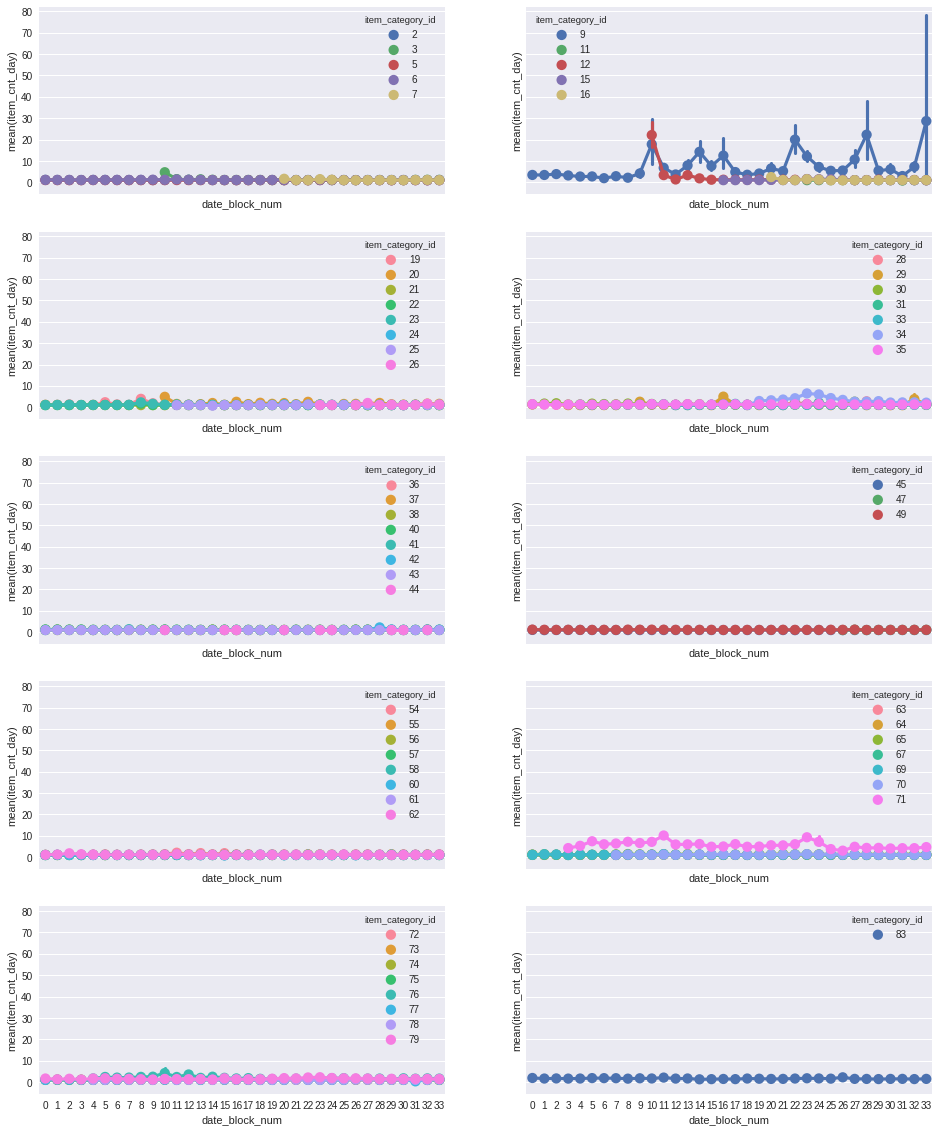

In [26]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))

num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

### Some more data 'wrangling' on the train set...

In [27]:
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()
train.head(25)

item_price  item_cnt_day  \
shop_id item_id date_block_num month year                             
2       30      2              3     2013      359.00           1.0   
                5              6     2013      399.00           1.0   
                15             4     2014      169.00           1.0   
                16             5     2014      169.00           1.0   
        31      1              2     2013     2796.00           4.0   
                2              3     2013      698.50           1.0   
                3              4     2013      699.00           1.0   
                16             5     2014      415.92           1.0   
                33             10    2015      399.00           1.0   
        32      12             1     2014      119.00           1.0   
                14             3     2014      149.00           1.0   
                18             7     2014      149.00           1.0   
                20             9     2014      298.00           2.0   
                21             10    2014      298.00           2.0   
                23             12    2014      298.00           2.0   
                26             3     2015      149.00           1.0   
                31             8     2015      149.00           1.0   
        33      0              1     2013      499.00           1.0   
                10             11    2013      398.00           2.0   
                11             12    2013      199.00           1.0   
                12             1     2014      199.00           1.0   
                20             9     2014      199.00           1.0   
                25             2     2015      199.00           1.0   
                27             4     2015      199.00           1.0   
                28             5     2015      199.00           1.0   

                                           day_of_month  
shop_id item_id date_block_num month year                
2       30      2              3     2013             1  
                5              6     2013            16  
                15             4     2014            20  
                16             5     2014             8  
        31      1              2     2013            85  
                2              3     2013             2  
                3              4     2013            12  
                16             5     2014            19  
                33             10    2015            25  
        32      12             1     2014            13  
                14             3     2014             2  
                18             7     2014             1  
                20             9     2014            45  
                21             10    2014            32  
                23             12    2014            51  
                26             3     2015             5  
                31             8     2015            28  
        33      0              1     2013             5  
                10             11    2013            32  
                11             12    2013            28  
                12             1     2014            29  
                20             9     2014             4  
                25             2     2015            17  
                27             4     2015            14  
                28             5     2015             9

## Train a Machine Learning Algorithm

### For a gradient-based learning method, it is common to normalize the numerical variables to speed up the training




In [0]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train.item_price.as_matrix().reshape(-1, 1))         # train.item_price is a numpy column vector
cnt_scaler.fit(train.item_cnt_day.as_matrix().reshape(-1, 1))   # item_cnt_day is a numpy column vector

train.item_price = scaler.transform(train.item_price.as_matrix().reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.as_matrix().reshape(-1, 1))

In [29]:
train['item_price'].head(20)

shop_id  item_id  date_block_num  month  year
2        30       2               3      2013   -0.248665
                  5               6      2013   -0.242961
                  15              4      2014   -0.275760
                  16              5      2014   -0.275760
         31       1               2      2013    0.098859
                  2               3      2013   -0.200251
                  3               4      2013   -0.200180
                  16              5      2014   -0.240548
                  33              10     2015   -0.242961
         32       12              1      2014   -0.282890
                  14              3      2014   -0.278612
                  18              7      2014   -0.278612
                  20              9      2014   -0.257364
                  21              10     2014   -0.257364
                  23              12     2014   -0.257364
                  26              3      2015   -0.278612
                  31      

In [30]:
train['item_cnt_day'].head(20)

shop_id  item_id  date_block_num  month  year
2        30       2               3      2013   -0.150189
                  5               6      2013   -0.150189
                  15              4      2014   -0.150189
                  16              5      2014   -0.150189
         31       1               2      2013    0.115543
                  2               3      2013   -0.150189
                  3               4      2013   -0.150189
                  16              5      2014   -0.150189
                  33              10     2015   -0.150189
         32       12              1      2014   -0.150189
                  14              3      2014   -0.150189
                  18              7      2014   -0.150189
                  20              9      2014   -0.061612
                  21              10     2014   -0.061612
                  23              12     2014   -0.061612
                  26              3      2015   -0.150189
                  31      

### It seems natural to try to encode the whole training set to feed to the network. However, this approach has two drawbacks:

*   It is unlikely that sale data from Jan 2013 or any time close by has any effect with sale of Nov 2015.
*   The memory requirements exceed the limit that Google Colabs provides.

Instead let's see what information can be obtained from the sequence of July, August, September, October, November in 2013 and 2014.

### Missing data
Not every item was sold in the above time period, we will add a record for them with item_cnt_day as 0. The price is a little bit tricky. As can be seen at the code below, price of an item depends on shop and point of time. We will fill in empty values with the closest past record.

In [31]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

month  year  item_price  item_cnt_day  \
item_id date_block_num shop_id                                          
30      1              3            2  2013   -0.072265      0.115543   
                       4            2  2013    0.041532      0.381274   
                       5            2  2013   -0.072265      0.204120   
                       6            2  2013    0.314142      2.241392   
                       7            2  2013    0.149626      0.647005   
                       10           2  2013   -0.186490      0.115543   
                       12           2  2013   -0.242961     -0.150189   
                       14           2  2013    0.149626      0.469851   
                       15           2  2013    0.208426      1.178467   
                       16           2  2013    0.097005      1.178467   
                       18           2  2013   -0.072265      0.292697   
                       19           2  2013    0.152478      1.089890   
                       21           2  2013    0.098431      0.912736   
                       22           2  2013    0.041532      0.558428   
                       24           2  2013    0.326026      1.089890   
                       25           2  2013    0.439823      4.012933   
                       26           2  2013    0.316329      1.709929   
                       28           2  2013    0.661704      4.987280   
                       31           2  2013    0.665965      9.681864   
                       35           2  2013    0.142971      1.178467   
                       37           2  2013    0.212228      1.089890   
                       38           2  2013    0.098431      0.469851   
                       41           2  2013   -0.186062     -0.061612   
                       42           2  2013    0.548283      3.835779   
                       44           2  2013    0.269127      1.355621   
                       45           2  2013   -0.015366      0.292697   
                       46           2  2013    0.382925      1.621352   
                       47           2  2013    0.089854      0.647005   
                       50           2  2013    0.494821      2.329969   
                       52           2  2013   -0.129164      0.204120   
...                               ...   ...         ...           ...   
22167   30             52           7  2015   -0.214583     -0.061612   
        31             2            8  2015   -0.257221     -0.150189   
                       12           8  2015   -0.129306      0.115543   
                       22           8  2015    0.041247      0.912736   
                       25           8  2015   -0.214583     -0.061612   
                       26           8  2015   -0.257221     -0.150189   
                       31           8  2015   -0.257221     -0.150189   
                       35           8  2015   -0.257221     -0.150189   
                       39           8  2015   -0.257221     -0.150189   
                       42           8  2015   -0.171945      0.026965   
                       52           8  2015   -0.214583     -0.061612   
        32             12           9  2015   -0.044030      0.292697   
                       21           9  2015   -0.214583     -0.061612   
                       22           9  2015   -0.129306      0.115543   
                       24           9  2015   -0.257221     -0.150189   
                       25           9  2015   -0.129306      0.115543   
                       42           9  2015   -0.171945      0.115543   
        33             6           10  2015   -0.257221     -0.150189   
                       10          10  2015   -0.277756     -0.150189   
                       12          10  2015   -0.001391      0.381274   
                       18          10  2015   -0.257221     -0.150189   
                       21          10  2015   -0.257221     -0.150189   
                 

### For easier analysis, let's change the grouping order a little bit...

In [32]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price.head(20)

month  year  item_price  item_cnt_day  \
item_id shop_id date_block_num                                          
30      2       2                   3  2013   -0.248665     -0.150189   
                5                   6  2013   -0.242961     -0.150189   
                15                  4  2014   -0.275760     -0.150189   
                16                  5  2014   -0.275760     -0.150189   
31      2       1                   2  2013    0.098859      0.115543   
                2                   3  2013   -0.200251     -0.150189   
                3                   4  2013   -0.200180     -0.150189   
                16                  5  2014   -0.240548     -0.150189   
                33                 10  2015   -0.242961     -0.150189   
32      2       12                  1  2014   -0.282890     -0.150189   
                14                  3  2014   -0.278612     -0.150189   
                18                  7  2014   -0.278612     -0.150189   
                20                  9  2014   -0.257364     -0.061612   
                21                 10  2014   -0.257364     -0.061612   
                23                 12  2014   -0.257364     -0.061612   
                26                  3  2015   -0.278612     -0.150189   
                31                  8  2015   -0.278612     -0.150189   
33      2       0                   1  2013   -0.228701     -0.150189   
                10                 11  2013   -0.243104     -0.061612   
                11                 12  2013   -0.271482     -0.150189   

                                day_of_month  
item_id shop_id date_block_num                
30      2       2                          1  
                5                         16  
                15                        20  
                16                         8  
31      2       1                         85  
                2                          2  
                3                         12  
                16                        19  
                33                        25  
32      2       12                        13  
                14                         2  
                18                         1  
                20                        45  
                21                        32  
                23                        51  
                26                         5  
                31                        28  
33      2       0                          5  
                10                        32  
                11                        28

In [33]:
price = price.sort_index()
price.head(20)

month  year  item_price  item_cnt_day  \
item_id shop_id date_block_num                                          
30      2       2                   3  2013   -0.248665     -0.150189   
                5                   6  2013   -0.242961     -0.150189   
                15                  4  2014   -0.275760     -0.150189   
                16                  5  2014   -0.275760     -0.150189   
        3       1                   2  2013   -0.072265      0.115543   
                2                   3  2013   -0.072265      0.204120   
                3                   4  2013   -0.186062     -0.061612   
                4                   5  2013   -0.186062     -0.061612   
                5                   6  2013   -0.242961     -0.150189   
                9                  10  2013   -0.275760     -0.150189   
                10                 11  2013   -0.275760     -0.150189   
                11                 12  2013   -0.251660     -0.061612   
                12                  1  2014   -0.275760     -0.150189   
                30                  7  2015   -0.281464     -0.150189   
        4       1                   2  2013    0.041532      0.381274   
                2                   3  2013   -0.129164      0.026965   
                7                   8  2013   -0.242961     -0.150189   
        5       1                   2  2013   -0.072265      0.204120   
                2                   3  2013    0.041532      0.381274   
                3                   4  2013   -0.242961     -0.150189   

                                day_of_month  
item_id shop_id date_block_num                
30      2       2                          1  
                5                         16  
                15                        20  
                16                         8  
        3       1                         90  
                2                         66  
                3                         27  
                4                         22  
                5                         13  
                9                         18  
                10                        11  
                11                        27  
                12                        29  
                30                        17  
        4       1                        116  
                2                         16  
                7                         29  
        5       1                         80  
                2                         84  
                3                         22

### Let's define some functions to help with missing values in the data...

In [0]:
def convert(date_block):                                                # Determines associated month and year of a date_block
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):                  # Find the block_date which is closest to the current_day, 
    if (item_id, shop_id) in price.index:                               # given item_id and shop_id. Returns index integer.
      search_lst = np.array(price.loc[(item_id, shop_id)].index)        
      return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
      return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)


In [0]:
assert closest_date_block(18, 30, 5) == 18                             # Test the closest_data_block function with known correct values

### Some simple tests to verify the functionality of 'convert'.

In [36]:
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


### We will do some math to find out what block we should train on...

In [0]:
maxlen = 4                 # 4 months
step = 1

sentences = [[],[],[]]     # 0: train, 1: val, 2:test
next_chars = [[], []]
BLOCKS = [6, 18, 30]                         

In [0]:
for s in test_shops:                                                      # test_shops = test.shop_id.unique()
    shop_items = list(train.loc[s].index.get_level_values(0).unique())    # get unique 'item_id's for each 'shop_id' in test
    
    for it in shop_items:  
      
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)       #  def closest_price(current_day, item_id, shop_id)    
            
            for j in range(maxlen+1):
                
                if j < maxlen:        # j = 4
                    
                    if (s, it, i+j) in train.index:    # is a test 'shop_id' and corresonding 'item_id' and 'date_block' in train?
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')    # if true, identify the row indices and store in r             
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    
                    sentence.append(row)
                
                elif i_index < 2:                       # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

We specify $x_{0,train}$, $x_{0,val}$, and $x_{0,test}$

In [0]:
x_train_o = np.array(sentences[0])                    
x_val_o = np.array(sentences[1])
x_test_o = np.array(sentences[2])                                # X_test_0 input to determine y_test
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])

In [0]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1   # = 5149

In [0]:
from sklearn import preprocessing

shop_le = preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm = dict(zip(test_shops, shop_le.transform(test_shops)))

item_le = preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm = dict(zip(test_items, item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()                 # July through November
month_le.fit(range(7,11))
month_dm = dict(zip(range(7,11), month_le.transform(range(7,11))))

In [0]:
def vectorize(inp):
  
    print('Vectorization...')   
    
    x = np.zeros((len(inp), maxlen, length), dtype=np.float32)
    
    for i, sentence in enumerate(inp):
        for t, char in enumerate(sentence):            
            x[i][t][ shop_dm[char['shop_id']] ] = 1        
            x[i][t][ MAX_SHOP + item_dm[char['item_id']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + month_dm[char['month']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 ] = char['item_price']
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1] = char['item_cnt_day']    
    return x

In [0]:
x_train = vectorize(x_train_o)
x_val = vectorize(x_val_o)
x_test = vectorize(x_test_o)

### Build the model: a single LSTM Recurrent Neural Network.

In [0]:
print('Build the LSTM RNN model...')
model = Sequential()
model.add(LSTM(32, input_shape=(maxlen, length)))
model.add(Dense(1, activation='relu'))

optimizer = RMSprop(lr=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(x_train, y_train, batch_size=128, epochs=13)

### Below is the evaluation code for the model. 

In [0]:
import math
from sklearn.metrics import mean_squared_error

# make predictions

predict_train = model.predict(x_train)
predict_val = model.predict(x_val)

# invert predictions

predict_train = cnt_scaler.inverse_transform(predict_train)
y_train = cnt_scaler.inverse_transform(y_train)
predict_val = cnt_scaler.inverse_transform(predict_val)
y_val = cnt_scaler.inverse_transform(y_val)

# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(predict_train, y_train))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(predict_val, y_val))
print('Test Score: %.2f RMSE' % (valScore))

#For 1 epoch
#Train Score: 3.85 RMSE
#Test Score: 4.29 RMSE

### The learning seems to converge. We will then incrementally train on the validation set (why does it work)

In [0]:
model.fit(x_val, y_val, batch_size=128, epochs=13)

## Inference

With everything prepared, let's now let the model work on the test set.

In [0]:
predict_test = model.predict(x_test)
predict_test = cnt_scaler.inverse_transform(predict_test)

In [0]:
test = test.set_index(['shop_id', 'item_id'])
test['item_cnt_month'] = 0

In [0]:
for index, sentence in enumerate(x_test_o):
    (shop_id, item_id) = (sentence[0]['shop_id'], sentence[0]['item_id'])
    test.loc[(shop_id, item_id)]['item_cnt_month'] = predict_test[index]

In [0]:
test = test.reset_index().drop(['shop_id', 'item_id'], axis=1)
test.to_csv('submission.csv', index=False)